In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
from Bio import SeqIO
import glob
import copy
import sys
import pysam
import glob
import os

sys.path.append('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/src')

from abundance_plots import MinorSymLogLocator

In [ ]:
test = np.save

In [2]:
df_virus = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/df_virus_filtered.csv', index_col=0)
df_virus.index = [i.split(' -')[0] for i in df_virus.index]
bam_mappings = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/data/bam_mappings.csv', sep='\t', index_col=1)

In [70]:
def saveHighResFig(fig_name):
    plt.tight_layout()
    plt.savefig('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/paper/viral_integration/%s.png' % fig_name, 
                transparent=True, bbox_inches='tight', format='png', dpi=500)

In [62]:
def GetCoverage(sample, contig_names, save_file):
    batch = bam_mappings.loc[sample].get('sequencing_plate').replace('MTR-', '')
    decoy_contig = 'chrUn_JTFH01000690v1_decoy'

    # Extract reads    
    with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.paired.aln_all.bam" % (batch, sample.replace('_','-'), sample.replace('_','-')), "r") as samfile:
        proper_reads = [r  for c in contig_names for r in samfile.fetch(c) if (~r.is_supplementary & ~r.is_secondary)]
    #with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.paired.aln_all.bam" % (batch, sample, sample), "r") as samfile:
    #    improper_reads = [r  for c in contig_names for r in samfile.fetch(c) if (~r.is_proper_pair & ~r.is_supplementary & ~r.is_secondary)]
    with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.paired.aln_all.bam" % (batch, sample.replace('_','-'), sample.replace('_','-')), "r") as samfile:
        mated_with_unmapped_reads = [r  for c in contig_names for r in samfile.fetch(c) if (r.mate_is_unmapped & ~r.is_supplementary & ~r.is_secondary)]
    with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.single.aln_all.bam" % (batch, sample.replace('_','-'), sample.replace('_','-')), "r") as samfile:
        mated_with_ref_genome_dict = {r.query_name:r for c in contig_names for r in samfile.fetch(c) if (~r.is_supplementary & ~r.is_secondary)}
    with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.map_unmap.bam" % (batch, sample.replace('_','-'), sample.replace('_','-')), "r") as samfile:
        decoy_dict = {r.query_name:r for r in samfile.fetch(decoy_contig)}
    
    # Compute coverage
    decoy_pair_keys = set(decoy_dict.keys()).intersection(set(mated_with_ref_genome_dict.keys()))
    decoy_reads = [decoy_dict[i] for i in decoy_pair_keys]
    mated_with_decoy_reads = [mated_with_ref_genome_dict[i] for i in decoy_pair_keys]
    
    proper_pair_ids = Counter([p.query_name for p in proper_reads])
    proper_reads_same_chrom = [p for p in proper_reads if proper_pair_ids[p.query_name]==2]
        
    if len(proper_reads)>0: proper_coverage = np.concatenate([r.get_reference_positions() for r in proper_reads])
    else: proper_coverage = []
    #if len(improper_reads)>0: improper_coverage = np.concatenate([r.get_reference_positions() for r in improper_reads])
    #else: improper_coverage = []
    if len(mated_with_decoy_reads)>0: mated_with_decoy_coverage = np.concatenate([r.get_reference_positions() for r in mated_with_decoy_reads])
    else: mated_with_decoy_coverage = []
    if len(mated_with_unmapped_reads)>0:  mated_with_unmapped_coverage = np.concatenate([r.get_reference_positions() for r in mated_with_unmapped_reads])
    else: mated_with_unmapped_coverage = []
    if len(decoy_reads)>0: decoy_coverage = np.concatenate([r.get_reference_positions() for r in decoy_reads])
    else: decoy_coverage = []
    
    # Create and save dictionary.
    coverage_dict = dict()
    coverage_dict['proper_coverage'] = proper_coverage
    #coverage_dict['improper_coverage'] = improper_coverage
    coverage_dict['mated_with_decoy_coverage'] = mated_with_decoy_coverage
    coverage_dict['mated_with_unmapped_coverage'] = mated_with_unmapped_coverage
    coverage_dict['decoy_coverage'] = decoy_coverage
    np.save(save_file, coverage_dict)
    for f in glob.glob('%s.*.bai' % sample):
        os.remove(f)
    return coverage_dict
    
    

def CoverageHistograms(coverage_dicts, bins_virus, bins_decoy):
    f, ax = plt.subplots(ncols=4,figsize=(25,3))
    n_avg_paired = np.zeros(len(bins_virus)-1)
    #n_avg_improper = np.zeros(len(bins_virus)-1)
    n_avg_paired_with_unmapped = np.zeros(len(bins_virus)-1)
    n_avg_paired_with_decoy = np.zeros(len(bins_virus)-1)
    n_avg_decoy_seq = np.zeros(len(bins_decoy)-1)

    for s in coverage_dicts.keys():
        
        # Virus-Virus coverage:
        n,_ = np.histogram(coverage_dicts[s]['proper_coverage'], bins=bins_virus)
        n_avg_paired = n_avg_paired + n/sum(n)
        ax[0].plot((bins_virus[1:]+bins_virus[:-1])/2, n/sum(n), color='grey', alpha=.5)
        
        # Virus-Virus coverage:
        #n,_ = np.histogram(coverage_dicts[s]['improper_coverage'], bins=bins_virus)
        #n_avg_improper = n_avg_improper + n/sum(n)
        #ax[1].plot((bins_virus[1:]+bins_virus[:-1])/2, n/sum(n), color='grey', alpha=.5)

        # Virus-Unmapped coverage
        if len(coverage_dicts[s]['mated_with_unmapped_coverage'])>0:
            n,_ = np.histogram(coverage_dicts[s]['mated_with_unmapped_coverage'], bins=bins_virus)
            n_avg_paired_with_unmapped = n_avg_paired_with_unmapped + n/sum(n)
            ax[1].plot((bins_virus[1:]+bins_virus[:-1])/2, n/sum(n), color='grey', alpha=.5)

        else:
            ax[1].plot((bins_virus[1:]+bins_virus[:-1])/2, 0*bins_virus[1:], color='grey', alpha=.3)

        # Virus-decoy pairs
        if len(coverage_dicts[s]['mated_with_decoy_coverage'])>0:
            n,_ = np.histogram(coverage_dicts[s]['mated_with_decoy_coverage'], bins=bins_virus)
            n_avg_paired_with_decoy = n_avg_paired_with_decoy + n/sum(n)
            ax[2].plot((bins_virus[1:]+bins_virus[:-1])/2, n/sum(n), color='grey', alpha=.5)
            
            n,_ = np.histogram(coverage_dicts[s]['decoy_coverage'], bins=bins_decoy)
            n_avg_decoy_seq = n_avg_decoy_seq + n/sum(n)
            ax[3].plot((bins_decoy[1:]+bins_decoy[:-1])/2, n/sum(n), color='grey', alpha=.5)

        else:
            ax[2].plot((bins_virus[1:]+bins_virus[:-1])/2, 0*bins_virus[1:], color='grey', alpha=.3)
            ax[3].plot((bins_decoy[1:]+bins_decoy[:-1])/2, 0*bins_decoy[1:], color='grey', alpha=.5)
            
            
    ax[0].plot((bins_virus[1:]+bins_virus[:-1])/2, n_avg_paired/len(coverage_dicts), color='orange', alpha=1)
    ax[1].plot((bins_virus[1:]+bins_virus[:-1])/2, n_avg_paired_with_unmapped/len(coverage_dicts), color='orange', alpha=1)
    ax[2].plot((bins_virus[1:]+bins_virus[:-1])/2, n_avg_paired_with_decoy/len(coverage_dicts), color='orange', alpha=1)
    ax[3].plot((bins_decoy[1:]+bins_decoy[:-1])/2, n_avg_decoy_seq/len(coverage_dicts), color='orange', alpha=1)

    for i in range(4):
        ax[i].set_yticks([])
        ax[i].set(frame_on=False)
        ax[i].locator_params(nbins=5)

In [105]:
df_virus = df_virus[['Human herpesvirus 6A', 'Human herpesvirus 6B', 'Human herpesvirus 7', 'type','family']]

In [64]:
herpes_7_contigs = {'AF037218.1','KF558370.1', 'MH507176.1','MH507177.1','MK619207.1','MT314265.1','MT314266.1','MT314267.1','MT314268.1',
                    'MT314269.1','NC_001716.2','VIRL|gi|51874225|ref|NC_001716.2|'}
herpes_6A_contigs =  {'JX152762.1','KC465951.1','KP026965.1','KP257584.1','KT355575.1','KY316047.1','KY316048.1',
                      'KY316049.1','KY316054.1','KY316055.1','KY316056.1','MF994813.1','MF994815.1','MF994816.1',
                      'MF994817.1','MF994818.1','MF994819.1','MF994820.1','MF994822.1','MF994828.1','MH698400.1',
                      'MH698403.1','MK630133.1','MK630134.1','MN079022.1','MN079023.1','MN079024.1','NC_001664.4',
                      'U04437.1','U13194.1','U23467.1','VIRL|gi|224020395|ref|NC_001664.2|','X83413.2'}
herpes_6B_contigs = {'EU861010.1','EU861011.1','EU861012.1','EU861013.1','EU861014.1','EU861015.1','EU861016.1','EU861017.1','EU861018.1',
                     'EU861019.1','EU861020.1','EU861021.1','EU861022.1','EU861023.1','EU861024.1','EU861025.1','EU861026.1','EU861027.1',
                     'EU861028.1','FJ610376.1','FJ610377.1','FJ610378.1','FJ610379.1','FJ610380.1','FJ610381.1','FJ610382.1','FJ610383.1',
                     'FJ610384.1','FJ610385.1','FJ610386.1','FJ610387.1','FJ610388.1','FJ610389.1','FJ610390.1','FJ610391.1','FJ610392.1',
                     'FJ610393.1','FJ610394.1','FJ610395.1','FJ610396.1','FJ610397.1','FJ610398.1','FJ610399.1','FJ610400.1','FJ610401.1',
                     'FJ610402.1','FJ610403.1','FJ610404.1','FJ610405.1','FJ610406.1','FJ610407.1','FJ610408.1','FJ610409.1','FJ610410.1',
                     'FJ610411.1','FJ610412.1','FJ610413.1','FJ610414.1','FJ610415.1','FJ610416.1','FJ610417.1','FJ610418.1','FJ610419.1',
                     'FJ610420.1','FJ610421.1','FJ610422.1','FJ610423.1','FJ610424.1','FJ610425.1','FJ610426.1','FJ610427.1','FJ610428.1',
                     'FJ610429.1','FJ610430.1','FJ610431.1','FJ610432.1','FJ610433.1','FJ610434.1','FJ610435.1','FJ610436.1','FJ610437.1',
                     'FJ610438.1','JX235339.1','KF130944.1','KF130945.1','KF130946.1','KF130947.1','KX595170.1','KY316030.1','KY316031.1',
                     'KY316032.1','KY316033.1','KY316034.1','KY316035.1','KY316036.1','KY316037.1','KY316038.1','KY316039.1','KY316040.1',
                     'KY316041.1','KY316042.1','KY316043.1','KY316044.1','KY316045.1','KY316046.1','KY316050.1','KY316051.1','KY316052.1',
                     'KY316053.1','MF624253.1','MF624254.1','MF624255.1','MF624256.1','MF624257.1','MF624258.1','MF624259.1','MF624260.1',
                     'MF624261.1','MF624262.1','MF624263.1','MF994814.1','MF994821.1','MF994823.1','MF994824.1','MF994825.1','MF994826.1',
                     'MF994827.1','MF994829.1','MH507178.1','MH698398.1','MH698399.1','MH698401.1','MH698402.1','MK388090.1','MK629887.1',
                     'MK629888.1','MK629889.1','MK629890.1','MK629891.1','MK629892.1','MK629893.1','MK629894.1','MK629895.1','MK629896.1',
                     'MK629897.1','MK629898.1','MK629899.1','MK629900.1','MK629901.1','MK629902.1','MK629903.1','MK629904.1','MK629905.1',
                     'MK629906.1','MK629907.1','MK629908.1','MK629909.1','MK629910.1','MK629911.1','MK629912.1','MK629913.1','MK629914.1',
                     'MK629915.1','MK629916.1','MK629917.1','MK629918.1','MK629919.1','MK629920.1','MK629921.1','MK629922.1','MK629923.1',
                     'MK629924.1','MK629925.1','MK629926.1','MK629927.1','MK629928.1','MK629929.1','MK629930.1','MK629931.1','MK629932.1',
                     'MK629933.1','MK629934.1','MK629935.1','MN242397.1','NC_000898.1', 'VIRL|gi|9633069|ref|NC_000898.1|'}


# General Abundances

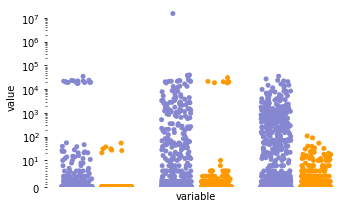

In [108]:
df_melt = df_virus.melt(id_vars=['type','family'])
plt.figure(figsize=(5,3))
sns.stripplot(data=df_melt, y='value', x='variable', hue='type',jitter=.3,palette=['#ff9900', '#8687d1'], dodge=True)
plt.yscale("symlog", linthresh=10)
plt.ylim(0,df_melt['value'].max().max()*2)
yaxis = plt.gca().yaxis
plt.legend().remove()
plt.xticks([])
yaxis.set_minor_locator(MinorSymLogLocator(10))
plt.tight_layout()
plt.box(on=None)
saveHighResFig('herpes_abundances_vs_cell_type')
plt.show()

In [129]:
Counter([(i,j) for i,j in zip(df_virus['Human herpesvirus 6B']>1000, bam_mappings.loc[df_virus.index].relationship=='sibling')])

Counter({(False, True): 2625,
         (False, False): 1869,
         (True, False): 20,
         (True, True): 54})

In [122]:
288/1798

0.16017797552836485

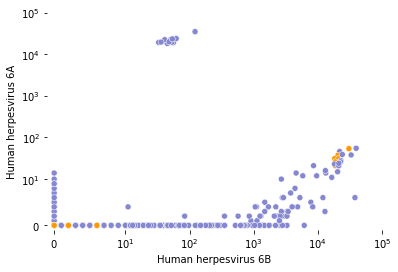

In [111]:
sns.scatterplot(data=df_virus, y='Human herpesvirus 6A', x='Human herpesvirus 6B', hue='type',palette=['#8687d1', '#ff9900'])
plt.xscale("symlog", linthresh=10)
plt.yscale("symlog", linthresh=10)
plt.ylim(-1,10**5)
plt.xlim(-1,10**5)
plt.box(on=None)

plt.legend().remove()
plt.show()

^ Note that the cluster of WB 6A around ~10 look like they are actually reads coming from H6B.

# Herpesvirus 6A
This should be pretty straightforward. Very clear cluster at expected abundance levels of germline integration of 6A.

In [3]:
bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6A']>1000].sort_values('family').index].bio_seq_source

03C16028    LCL
03C16815    LCL
03C16818    LCL
02C11465    LCL
03C16621    LCL
03C16623    LCL
04C37990    LCL
03C16632    LCL
03C16633    LCL
03C16634    LCL
06C54349    LCL
06C54347    LCL
06C54351    LCL
06C53148    LCL
06C53149    LCL
06C53151    LCL
Name: bio_seq_source, dtype: object

^ Except for one weird sample, no evidence of de novo integration. No children showed germline integration without parents.

**03C16028** -- this is the weird sample that looks like de novo herpes 6A AND de novo herpes 6B germline, and has a TON of herpes 6B

In [506]:
print(df_virus['Human herpesvirus 6A'].loc[bam_mappings[bam_mappings.family=='AU0164'].index])
bam_mappings[bam_mappings.family=='AU0164']

sample_id
03C16026       0.0
03C16027       2.0
03C16028    8945.0
03C16639       1.0
Name: Human herpesvirus 6A, dtype: float64


,status,participant_id,family,AGRE Blood,NIMH Blood,relationship,FatherID,MotherID,sex_numeric,derived_affected_status,...,number_of_indels,number_of_homozygous_snvs,number_of_heterozygous_snvs,het_to_hom_ratio,ti_tv_ratio,dbsnp_overlap,concordance_with_genotyping_chip,cryptic_relatedness_check,family_based_average_coverage,familial_relationship_check
sample_id,,,,,,,,,,,,,,,,,,,,,
03C16026,Passed_QC_analysis_ready,AU016401,AU0164,HI0436,03C16026,mother,0,0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C16027,Passed_QC_analysis_ready,AU016403,AU0164,HI0437,03C16027,sibling,AU016402,AU016401,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C16028,Passed_QC_analysis_ready,AU016404,AU0164,HI0442,03C16028,sibling,AU016402,AU016401,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C16639,Passed_QC_analysis_ready,AU016402,AU0164,HI2210,03C16639,father,0,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Herpes 6A -- Germline integration.

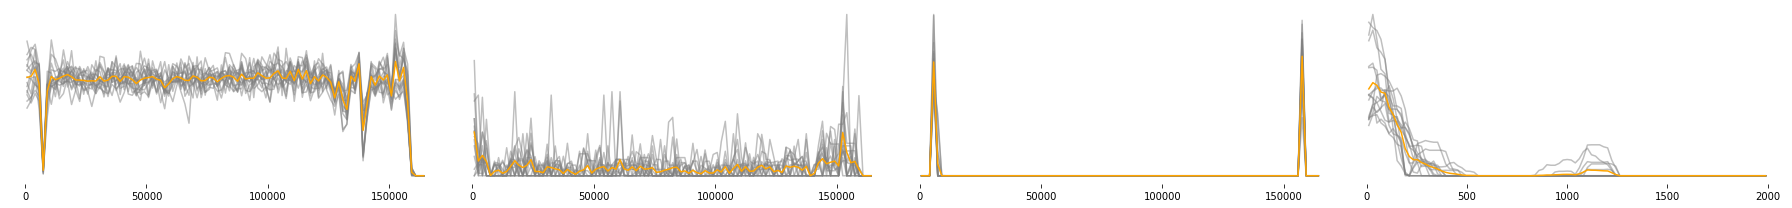

In [72]:
coverage_dir = '/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/herpes_coverages/herpes_6A_'
contig_names = {'VIRL|gi|224020395|ref|NC_001664.2|','NC_001664.4'}
    
coverage_dicts = dict()
for sample in bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6A']>1000].sort_values('family').index].iloc[1:].index:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6A_high')
plt.show()

## Herpes 6A -- Sample 03C16028.

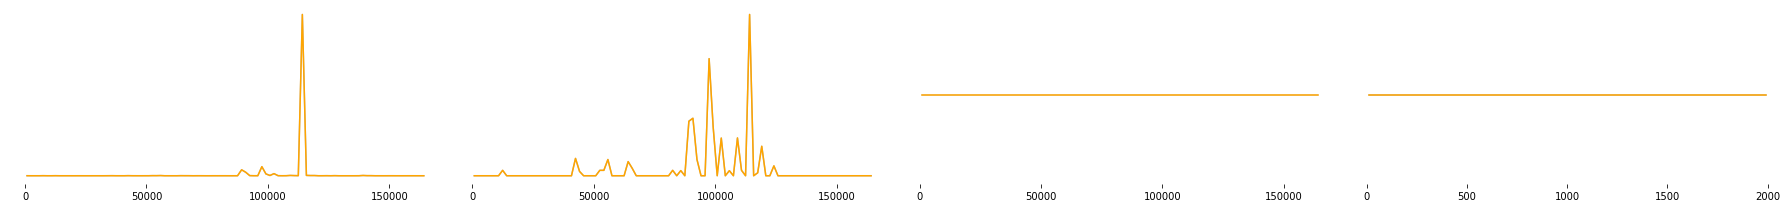

In [74]:
# Read in the weird sample for later use.
coverage_dicts = dict()
sample='03C16028'
filename = coverage_dir + sample + '.npy'
try: coverage_didcts[sample] = np.load(filename, allow_pickle=True).item()
except:
    coverage_dicts[sample] = GetCoverage(sample, {'VIRL|gi|224020395|ref|NC_001664.2|','NC_001664.4'}, filename)
CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6A_03C16028')

## Herpes 6A -- No integration

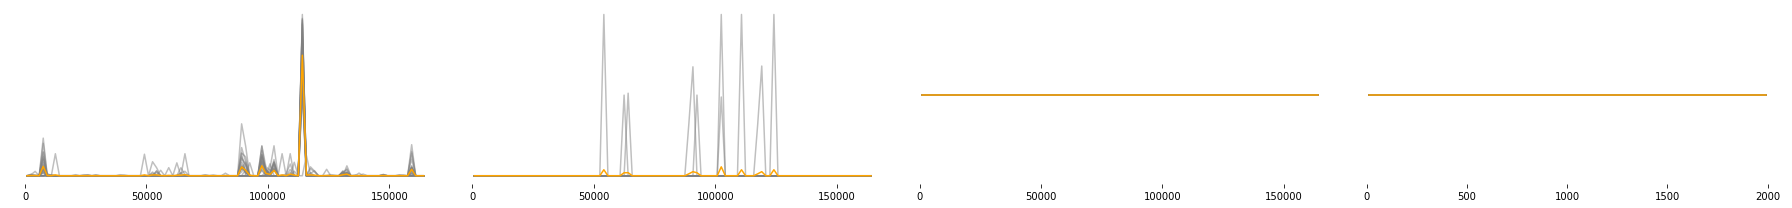

In [73]:
coverage_dicts = dict()
for sample in df_virus[(df_virus['Human herpesvirus 6A']<1000) & (df_virus['Human herpesvirus 6A']>10)].sort_values('family').index:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        print('retrieving sample ', sample)
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6A_low')
plt.show()

No handles with labels found to put in legend.


<Figure size 720x720 with 0 Axes>

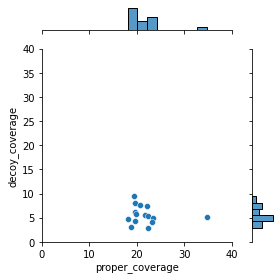

In [75]:
herpes_6A = df_virus[(df_virus['Human herpesvirus 6A']>1000)].index
coverage_dicts = dict()
for sample in herpes_6A:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

samples = list(coverage_dicts.keys())
decoy_coverage = np.array([len(coverage_dicts[c]['decoy_coverage'])/len(np.unique(coverage_dicts[c]['decoy_coverage'])) for c in coverage_dicts])
mated_w_decoy_coverage = np.array([len(coverage_dicts[c]['mated_with_decoy_coverage'])/len(np.unique(coverage_dicts[c]['mated_with_decoy_coverage'])) for c in coverage_dicts])
proper_coverage = np.array([len(coverage_dicts[c]['proper_coverage'])/160000 for c in coverage_dicts])
mated_with_unmapped_coverage = np.array([len(coverage_dicts[c]['mated_with_unmapped_coverage'])/len(np.unique(coverage_dicts[c]['mated_with_unmapped_coverage'])) for c in coverage_dicts])
df = pd.DataFrame([decoy_coverage, mated_w_decoy_coverage, proper_coverage, mated_with_unmapped_coverage]).transpose()
df.columns = ['decoy_coverage', 'mated_w_decoy_coverage', 'proper_coverage', 'mated_with_unmapped_coverage']


for x in ['proper_coverage']:#, 'mated_w_decoy_coverage', 'proper_coverage', 'mated_with_unmapped_coverage']:
    for y in ['decoy_coverage']:#, 'mated_w_decoy_coverage', '', 'mated_with_unmapped_coverage']:
        if x<=y: continue
        plt.figure(figsize=(10,10))
        g=sns.jointplot(data=df, x=x, y=y, palette=['#8687d1', '#3b5c36'], height=4)
        g.ax_joint.legend().remove()
        g.ax_marg_x.set_xlim(0, 40)
        g.ax_marg_y.set_ylim(0, 40)
        plt.xlabel('total reads ratio')
        plt.ylabel('decoy:virus ratio')
        plt.tight_layout()
        plt.show()
#plt.savefig('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/paper/viral_integration/herpes_6A_total_vs_decoy.png', transparent=True, bbox_inches='tight', format='png', dpi=500)


# Herpes 6B

## Herpes 6B -- Highly suspected ancient integration

At least 2 family members have > 10000 reads.

In [6]:
herpes_6B_high = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6B']>10000].sort_values('family').index]
fams = herpes_6B_high.groupby('family').count()
herpes_6B_high[[f in list(fams[fams.status>1].index) for f in herpes_6B_high.family]]

,status,participant_id,family,AGRE Blood,NIMH Blood,relationship,FatherID,MotherID,sex_numeric,derived_affected_status,...,number_of_indels,number_of_homozygous_snvs,number_of_heterozygous_snvs,het_to_hom_ratio,ti_tv_ratio,dbsnp_overlap,concordance_with_genotyping_chip,cryptic_relatedness_check,family_based_average_coverage,familial_relationship_check
04C27828,Passed_QC_analysis_ready,AU0412303,AU0412,HI3009,04C27828,sibling,AU0412201,AU0412202,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04C27801,Passed_QC_analysis_ready,AU0412301,AU0412,HI2982,04C27801,sibling,AU0412201,AU0412202,2.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04C27795,Passed_QC_analysis_ready,AU0412202,AU0412,HI2976,04C27795,mother,0,0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C16635,Passed_QC_analysis_ready,AU080003,AU0800,HI2203,03C16635,sibling,AU080006,AU080001,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C16636,Passed_QC_analysis_ready,AU080001,AU0800,HI2205,03C16636,mother,0,0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05C49694,Passed_QC_analysis_ready,AU1589301,AU1589,HI4648,05C49694,sibling,AU1589201,AU1589202,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05C49695,Passed_QC_analysis_ready,AU1589302,AU1589,HI4649,05C49695,sibling,AU1589201,AU1589202,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05C49696,Passed_QC_analysis_ready,AU1589201,AU1589,HI4650,05C49696,father,0,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10C105333,Passed_QC_analysis_ready,AU2140305,AU2140,HI10221,10C105333,sibling,AU2140203,AU2140204,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10C105330,Passed_QC_analysis_ready,AU2140203,AU2140,HI10218,10C105330,father,0,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [281]:
df_virus.loc[herpes_6B_de_novo]['type']

03C15783    LCL
06C61448    LCL
07C66885    LCL
05C48098    LCL
09C90889    LCL
02C10855    LCL
Name: type, dtype: object

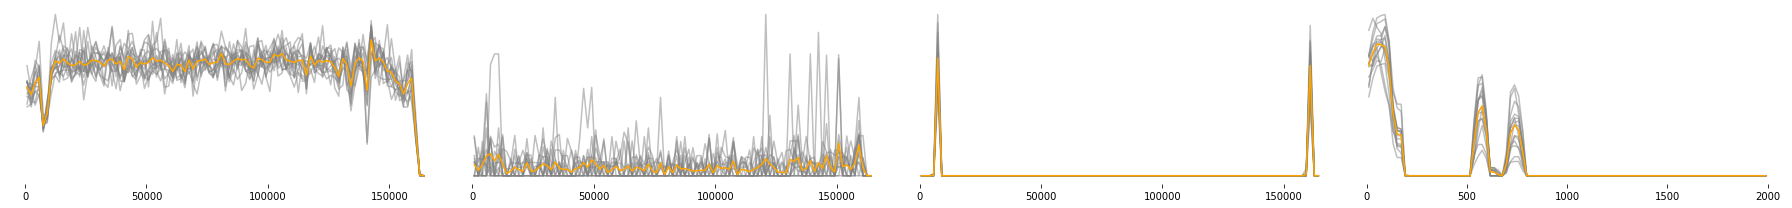

In [77]:
coverage_dir = '/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/herpes_coverages/herpes_6B_'
contig_names = {'VIRL|gi|9633069|ref|NC_000898.1|'}

herpes_6B_inherited = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6B']>10000].sort_values('family').index]
fams = herpes_6B_inherited.groupby('family').count()
herpes_6B_inherited = herpes_6B_inherited[[f in list(fams[fams.status>1].index) for f in herpes_6B_inherited.family]].index

coverage_dicts = dict()
for sample in herpes_6B_inherited:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6B_inherited')
plt.show()

In [24]:
print(Counter(df_virus.loc[herpes_6B_inherited]['type']))
print(Counter(df_virus['type']))

Counter({'LCL': 8, 'WB': 6})
Counter({'LCL': 3998, 'WB': 570})


## Herpes 6B -- possible de novo integration

In [42]:

herpes_6B_high = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 7']>10000].sort_values('family').index]
fams = herpes_6B_high.groupby('family').count()
Counter(herpes_6B_high[[f in list(fams[fams.status>0].index) for f in herpes_6B_high.family]].bio_seq_source)
#Counter(bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6B']>10000].sort_values('family').index].bio_seq_source)

Counter({'LCL': 11})

In [41]:
fam='AU1965'
print(df_virus['Human herpesvirus 7'].loc[set(bam_mappings[bam_mappings.family==fam].index).intersection(set(df_virus.index))])
bam_mappings[bam_mappings.family==fam]

07C65014    23699.0
07C65017        0.0
07C65016        5.0
07C65015        0.0
Name: Human herpesvirus 7, dtype: float64


,status,participant_id,family,AGRE Blood,NIMH Blood,relationship,FatherID,MotherID,sex_numeric,derived_affected_status,...,number_of_indels,number_of_homozygous_snvs,number_of_heterozygous_snvs,het_to_hom_ratio,ti_tv_ratio,dbsnp_overlap,concordance_with_genotyping_chip,cryptic_relatedness_check,family_based_average_coverage,familial_relationship_check
sample_id,,,,,,,,,,,,,,,,,,,,,
07C65014,Passed_QC_analysis_ready,AU1965201,AU1965,HI5367,07C65014,father,0,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07C65015,Passed_QC_analysis_ready,AU1965202,AU1965,HI5368,07C65015,mother,0,0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07C65016,Passed_QC_analysis_ready,AU1965301,AU1965,HI5369,07C65016,sibling,AU1965201,AU1965202,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07C65017,Passed_QC_analysis_ready,AU1965302,AU1965,HI5370,07C65017,sibling,AU1965201,AU1965202,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


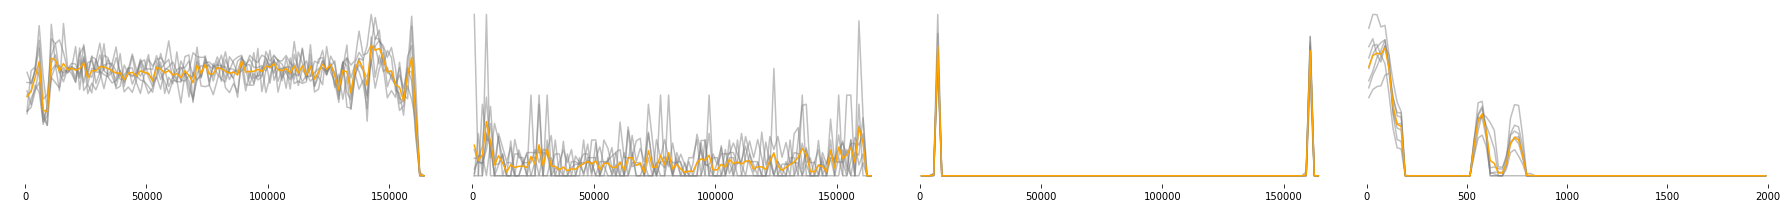

In [78]:
herpes_6B_high = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6B']>10000].sort_values('family').index]
fams = herpes_6B_high.groupby('family').count()
herpes_6B_de_novo = ['03C15783','06C61448', '07C66885','05C48098', '09C90889','02C10855', '02C10954'] # Keep track of which samples look like de novo.


coverage_dicts = dict()
for sample in herpes_6B_de_novo:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6B_de_novo')
plt.show()



## Herpes 6B -- LCL integration

In [36]:
print(Counter(df_virus.loc[herpes_6B_de_novo]['type']))
print(Counter(df_virus['type']))

Counter({'LCL': 7})
Counter({'LCL': 3998, 'WB': 570})


In [53]:
df_virus[(df_virus['Human herpesvirus 6B']>1000) & (df_virus['Human herpesvirus 6B']<10000)].sort_values('family').index


Index(['03C16639', '03C16027', '03C16026', '03C15957', '03C15961', '03C15960',
       '03C15958', 'HI1046', 'HI0519', '02C11468', '04C26314', '03C18588',
       '03C18587', '03C19904', '03C19907', '03C23533', '04C24823', '04C24822',
       '05C43192', '04C27223', '07C66516', '05C42028', '04C37211', '05C44402',
       '05C49381', '07C66916', '05C44551', '05C47166', '05C44479', '05C48541',
       '07C65962', '05C51757', '06C61548', '07C69667', '08C75508', '08C72996',
       '08C72997', '07C65815', '07C68916', '08C76295', '08C76417', '07C66849',
       '07C70167', '08C78111', '08C77354', '09C86431', '08C77361',
       '10C102516_LCL'],
      dtype='object')

In [48]:
Counter( bam_mappings.loc[df_virus[(df_virus['Human herpesvirus 7']>1000) & (df_virus['Human herpesvirus 7']<10000)].sort_values('family').index].bio_seq_source)

Counter({'LCL': 79})

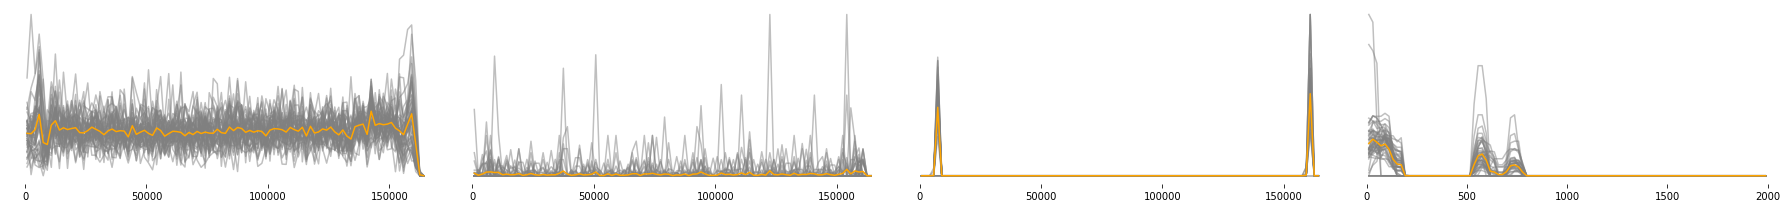

In [79]:
herpes_6B_medium = df_virus[(df_virus['Human herpesvirus 6B']>1000) & (df_virus['Human herpesvirus 6B']<10000)].sort_values('family').index
coverage_dicts = dict()
for sample in herpes_6B_medium:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)
CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6B_medium')
plt.show()

# Herpes 6B -- Not integrated

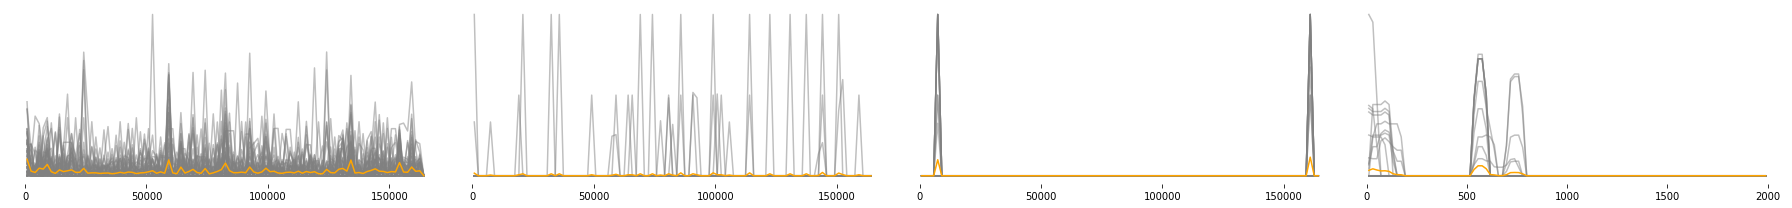

In [80]:
herpes_6B_low = df_virus[(df_virus['Human herpesvirus 6B']<500) & (df_virus['Human herpesvirus 6B']>10)].sort_values('family').index
coverage_dicts = dict()
for sample in herpes_6B_low:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)
CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6B_low')
plt.show()

In [84]:
coverage_dir = '/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/herpes_coverages/herpes_6B_'
contig_names = {'VIRL|gi|9633069|ref|NC_000898.1|'}

herpes_6B = df_virus[(df_virus['Human herpesvirus 6B']>10)].index
coverage_dicts = dict()
for sample in herpes_6B:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

samples = list(coverage_dicts.keys())
decoy_coverage = np.array([len(coverage_dicts[c]['decoy_coverage'])/(len(np.unique(coverage_dicts[c]['decoy_coverage']))+1) for c in coverage_dicts])
mated_w_decoy_coverage = np.array([len(coverage_dicts[c]['mated_with_decoy_coverage'])/(1+len(np.unique(coverage_dicts[c]['mated_with_decoy_coverage']))) for c in coverage_dicts])
proper_coverage = np.array([len(coverage_dicts[c]['proper_coverage'])/160000 for c in coverage_dicts])
mated_with_unmapped_coverage = np.array([len(coverage_dicts[c]['mated_with_unmapped_coverage'])/(1+len(np.unique(coverage_dicts[c]['mated_with_unmapped_coverage']))) for c in coverage_dicts])
df = pd.DataFrame([decoy_coverage, mated_w_decoy_coverage, proper_coverage, mated_with_unmapped_coverage]).transpose()
df.columns = ['decoy_coverage', 'mated_w_decoy_coverage', 'proper_coverage', 'mated_with_unmapped_coverage']
df['colors'] = ['likely inherited' if i in herpes_6B_inherited else 'unknown' for i in samples]

<Figure size 720x720 with 0 Axes>

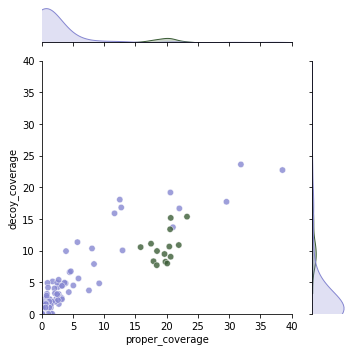

In [100]:
for x in ['proper_coverage']:#, 'mated_w_decoy_coverage', 'proper_coverage', 'mated_with_unmapped_coverage']:
    for y in ['decoy_coverage']:#, 'mated_w_decoy_coverage', '', 'mated_with_unmapped_coverage']:
        if x<=y: continue
        plt.figure(figsize=(10,10))
        g=sns.jointplot(data=df, x=x, y=y, hue='colors', palette=['#8687d1', '#3b5c36'], height=5,  s=40, alpha=.8)
        g.ax_joint.legend().remove()
        g.ax_marg_x.set_xlim(0, 40)
        g.ax_marg_y.set_ylim(0, 40)
        plt.xlabel('total reads ratio')
        plt.ylabel('decoy:virus ratio')
        plt.tight_layout()
plt.savefig('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/paper/viral_integration/herpes_6B_total_vs_decoy.png', transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

# Herpes 7

In [81]:
herpes_7_high = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 7']>1000].sort_values('family').index]
fams = herpes_7_high.groupby('family').count()
herpes_7_high[[f in list(fams[fams.status>0].index) for f in herpes_7_high.family]]

,status,participant_id,family,AGRE Blood,NIMH Blood,relationship,FatherID,MotherID,sex_numeric,derived_affected_status,...,number_of_indels,number_of_homozygous_snvs,number_of_heterozygous_snvs,het_to_hom_ratio,ti_tv_ratio,dbsnp_overlap,concordance_with_genotyping_chip,cryptic_relatedness_check,family_based_average_coverage,familial_relationship_check
05C43231-2,Passed_QC_analysis_ready,AU0025312,AU0025,HI3857,05C43231,sibling,AU0025211,AU0025212,2.0,broad-spectrum,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HI0385,Passed_QC_analysis_ready,AU013203,AU0132,HI0385,NaN,sibling,AU013202,AU013201,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HI0609,Passed_QC_analysis_ready,AU013205,AU0132,HI0609,NaN,sibling,AU013202,AU013201,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C21410,Passed_QC_analysis_ready,AU0316301,AU0316,HI2699,03C21410,sibling,AU0316201,AU0316202,2.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HI0366,Passed_QC_analysis_ready,AU032504,AU0325,HI0366,NaN,sibling,AU032502,AU032501,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
09C89180,Passed_QC_analysis_ready,AU2607202,AU2607,HI9453,09C89180,mother,0,0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09C98429,Passed_QC_analysis_ready,AU2757303,AU2757,HI9871,09C98429,sibling,AU2757201,AU2757202,2.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09C88944,Passed_QC_analysis_ready,AU2887304,AU2887,HI9438,09C88944,sibling,AU2887201,AU2887202,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09C88903,Passed_QC_analysis_ready,AU3197301,AU3197,HI9426,09C88903,sibling,AU3197201,AU3197202,2.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


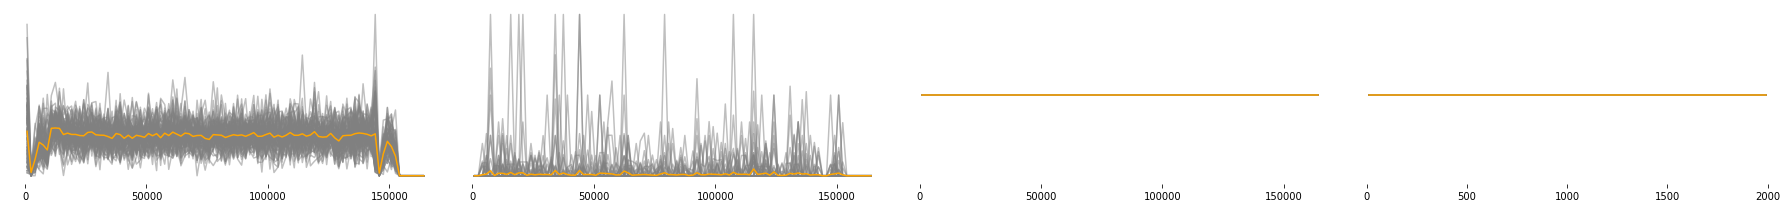

In [86]:
coverage_dir = '/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/herpes_coverages/herpes_7_'
contig_names = {'VIRL|gi|51874225|ref|NC_001716.2|'}
herpes_7_high = df_virus[df_virus['Human herpesvirus 7']>1000].sort_values('family').index

coverage_dicts = dict()
for sample in herpes_7_high:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        print(sample)
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_7')
plt.show()

## Herpes 7 -- High Load

In [55]:
try:
    df_herpes_7 = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_7_high.csv')
except:
    samples = [i for i in bam_mappings.loc[df_virus[(df_virus['Human herpesvirus 7']>5000)].sort_values('family').index].index if i !='03C16028']
    dfs_herpes_7 = [None for s in samples]
    for i,sample in enumerate(samples):
        print(sample)
        filename=glob.glob('/scratch/users/chloehe/unmapped_reads/bam/*/%s/%s.final_alignment_table.csv' % (sample, sample))[0]
        df = pd.read_csv(filename)
        df = df[(np.array([r in herpes_7_contigs for r in df.R1_ref])) | (np.array([r in herpes_7_contigs for r in df.R2_ref]))]
        df['sample']= sample
        dfs_herpes_7[i] = df
    #df_herpes_7 = pd.concat(dfs_herpes_7)
    #df_herpes_7.to_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_7_high.csv')

In [ ]:
CoverageHistograms(100, df_herpes_7,df_herpes_7,{'VIRL|gi|51874225|ref|NC_001716.2|'}, 'chrUn_JTFH01000690v1_decoy')
plt.tight_layout()
plt.savefig('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/paper/viral_integration/herpes_7_high.png',transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

## Herpes 7 -- Low load

In [396]:
samples = df_virus.loc[df_virus[(df_virus['Human herpesvirus 7']>10) & (df_virus['Human herpesvirus 7']<100)].sort_values('family').index]['Human herpesvirus 7'].index
print(sum(df_virus.loc[df_virus[(df_virus['Human herpesvirus 7']>10) & (df_virus['Human herpesvirus 7']<100)].sort_values('family').index]['Human herpesvirus 7']))
print(' '.join(samples))

3390.0
03C16014 03C16830 03C16034 02C12061 HI1146 05C40754 02C11625 05C45653 03C23223 05C44398 04C31673 03C21394 03C21394_LCL 04C31446 04C34137 05C50279 05C40019 05C40018 05C50288 05C47182 05C41367 04C35437 MH0134528 05C41994 04C37212 05C43238 05C50296 05C44474 04C37401 05C41357 05C45016 05C39267 06C52791 05C45450 05C44888 05C43258 05C45644 05C42701 05C43270 05C43828 05C44773 06C53579 05C47181 05C48976 05C51754 05C50306 05C48308 05C51556 05C48534 05C50070 06C53575 09C85276 05C51553 06C61140 06C55451 07C69751 07C69749 09C85275 09C85057 07C62597 08C73545 07C65183 07C66479 08C77269 07C66656 07C68916 07C66884 07C65977 07C69308 08C77365 07C69442 09C80267 09C86460 08C73791 10C114756 10C107310 08C77359 09C98376 09C82356 10C104045 11C122174 09C89701 09C86828 10C112859 10C108231 10C111728 10C112907 MH0143019 MH0130591


In [375]:
%%bash
\rm  /scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_6B_low.csv
for s in 03C16014 03C16830 03C16034 02C12061 HI1146 05C40754 02C11625 05C45653 03C23223 05C44398 04C31673 \
03C21394 03C21394_LCL 04C31446 04C34137 05C50279 05C40019 05C40018 05C50288 05C47182 05C41367 04C35437 \
MH0134528 05C41994 04C37212 05C43238 05C50296 05C44474 04C37401 05C41357 05C45016 05C39267 06C52791 05C45450 \
05C44888 05C43258 05C45644 05C42701 05C43270 05C43828 05C44773 06C53579 05C47181 05C48976 05C51754 05C50306 \
05C48308 05C51556 05C48534 05C50070 06C53575 09C85276 05C51553 06C61140 06C55451 07C69751 07C69749 09C85275 \
09C85057 07C62597 08C73545 07C65183 07C66479 08C77269 07C66656 07C68916 07C66884 07C65977 07C69308 08C77365 \
07C69442 09C80267 09C86460 08C73791 10C114756 10C107310 08C77359 09C98376 09C82356 10C104045 11C122174 09C89701 \
09C86828 10C112859 10C108231 10C111728 10C112907 MH0143019 MH0130591; do
    echo $s
    grep NC_001716.2 $(ls /scratch/users/chloehe/unmapped_reads/bam/*/$s/$s.final_alignment_table.csv) >> /scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_7_low.csv
done




Process is interrupted.


In [ ]:
ls /scratch/users/chloehe/unmapped_reads/bam/*/06C55451/06C55451.final_alignment_table.csv

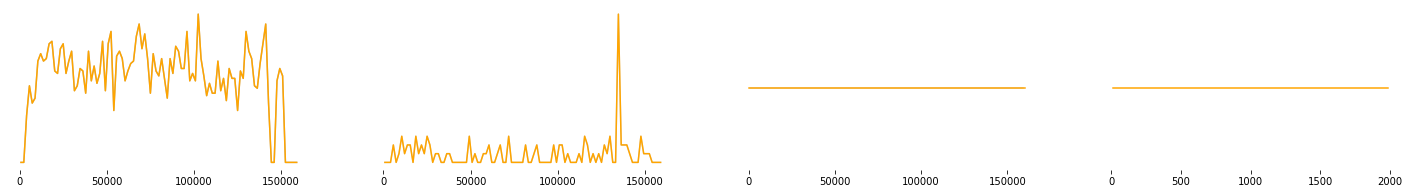

In [599]:
df_herpes_7 = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_7_low.csv', header=None)
df_herpes_7.columns = ['Unnamed:', 'R1_ref', 'R1_start', 'R1_MAPQ','R1_is_reverse', 'R2_ref', 'R2_start', 'R2_MAPQ', 'R2_is_reverse','is_proper_pair']
df_herpes_7['sample'] = 'combined'
counters_7_no_int = CoverageHistograms(100, df_herpes_7,herpes_7_contigs,{'VIRL|gi|51874225|ref|NC_001716.2|'}, 'chrUn_JTFH01000690v1_decoy',decoy_seq_bins=np.linspace(0,2000,100))


# Make table

In [139]:
hhv_summary = pd.DataFrame(np.zeros((6,3)), columns=['6A', '6B', '7'])